In [ ]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")
!pip install facenet-pytorch --no-deps

# Clean up the notebook
clean_notebook()


# Face detection from Webcam

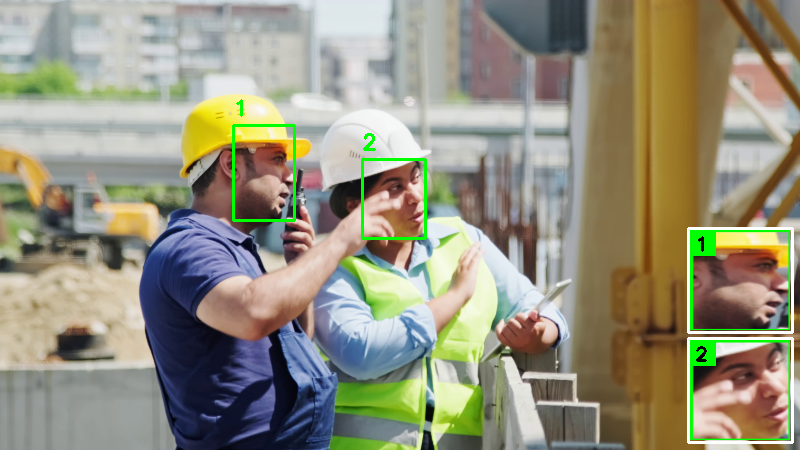

In [ ]:
import cv2
import numpy as np
import torch
from facenet_pytorch import MTCNN
from IPython.display import display, clear_output
from PIL import Image
import time

# Initialize the MTCNN model for face detection
mtcnn = MTCNN(keep_all=True, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

# ============ CHANGE HERE: Use local video file ============
video_path = '.././Videos/video2.mp4'  # Change this to your video path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file: {video_path}")
    cap.release()
    raise RuntimeError("Video initialization failed.")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video FPS: {fps}, Total frames: {total_frames}")

# Control playback speed to match original video FPS
frame_delay = 1.0 / fps if fps > 0 else 0.033

# Size of the cropped face display in the corner
CROP_DISPLAY_SIZE = 100  # Size of each face thumbnail
PADDING = 10  # Padding from the edge
GAP = 10  # Gap between face thumbnails

while True:
    start_time = time.time()
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("End of video or failed to grab frame.")
        break
    
    # Resize video frame for display
    ratio = 800.0 / frame.shape[1]
    frame = cv2.resize(frame, (800, int(frame.shape[0] * ratio)))
    
    # Convert frame to RGB (MTCNN expects RGB images)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect faces using MTCNN
    boxes, _ = mtcnn.detect(rgb_frame)
    
    cropped_faces = []  # Store all detected faces
    
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            # Ensure the bounding box is within the frame
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(frame.shape[1], x2), min(frame.shape[0], y2)
            
            # Skip if region is too small
            if x2 - x1 < 10 or y2 - y1 < 10:
                continue
            
            # Draw bounding box around the face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add label with index
            cv2.putText(frame, f'{i+1}', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Extract face region and resize
            face_region = frame[y1:y2, x1:x2].copy()
            face_resized = cv2.resize(face_region, (CROP_DISPLAY_SIZE, CROP_DISPLAY_SIZE))
            cropped_faces.append((i + 1, face_resized))  # Store index and face
    
    # Display all cropped faces in lower right corner (stacked vertically)
    if cropped_faces:
        h, w = frame.shape[:2]
        
        # Calculate total height needed for all faces
        total_height = len(cropped_faces) * CROP_DISPLAY_SIZE + (len(cropped_faces) - 1) * GAP
        
        # Starting position (lower right corner)
        x_offset = w - CROP_DISPLAY_SIZE - PADDING
        y_start = h - total_height - PADDING
        
        for idx, (face_idx, face_img) in enumerate(cropped_faces):
            # Calculate y position for this face
            y_offset = y_start + idx * (CROP_DISPLAY_SIZE + GAP)
            
            # Make sure we don't go outside the frame
            if y_offset < 0:
                continue
            
            # Create a border around the cropped face
            cv2.rectangle(frame, 
                          (x_offset - 2, y_offset - 2), 
                          (x_offset + CROP_DISPLAY_SIZE + 2, y_offset + CROP_DISPLAY_SIZE + 2), 
                          (255, 255, 255), 2)
            
            # Place the cropped face
            frame[y_offset:y_offset + CROP_DISPLAY_SIZE, 
                  x_offset:x_offset + CROP_DISPLAY_SIZE] = face_img
            
            # Add index label on the face thumbnail (top-left corner of thumbnail)
            cv2.rectangle(frame,
                          (x_offset, y_offset),
                          (x_offset + 25, y_offset + 25),
                          (0, 255, 0), -1)  # Filled green box
            cv2.putText(frame, f'{face_idx}', (x_offset + 5, y_offset + 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
    
    # Convert frame to PIL Image for Jupyter display
    display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(display_frame)
    
    # Clear previous output and display the frame
    clear_output(wait=True)
    display(pil_image)
    
    # Control playback speed
    elapsed = time.time() - start_time
    sleep_time = max(0, frame_delay - elapsed)
    time.sleep(sleep_time)

# Release video
cap.release()
print("Video processing complete.")